# HistAuGAN demo

Demo notebook for the GAN-based augmentation technique presented in "Structure-Preserving Multi-Domain Stain Color Augmentation using Style-Transfer with Disentangled" 
[add link to paper]

Structure
* Quickly summarize architecture of HistAuGAN
* Demonstrate that HistAuGAN works on examples from the five different domains of the Camelyon17 Dataset
    * Discrete domain, with same attribute
    * Discrete domain, with random attribute
    * Continuous domain with random attribute
* Qualitative evalutation from expert pathologist (show the paired tiles with Melanies annotations)
    * lymph nodes (Camelyon17)
    * breast

In [30]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from PIL import Image

from augmentations import generate_hist_augs, opts, mean_domains, std_domains
from histaugan.model import MD_multi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## HistAuGAN on Camelyon17

### Visualize sample patches

In [2]:
# add correct path to directory with sample tiles (5 images per domain, hence in total 25 tiles)
tiles_dir = 'sample_tiles/'
tile_names = os.listdir(tiles_dir)
tile_names.sort()
if '.ipynb_checkpoints' in tile_names:
    tile_names.pop(0)
print(tile_names)

['domain_0_15018.pt', 'domain_0_17628.pt', 'domain_0_4270.pt', 'domain_0_7810.pt', 'domain_0_8327.pt', 'domain_1_12919.pt', 'domain_1_20602.pt', 'domain_1_2680.pt', 'domain_1_701.pt', 'domain_1_8708.pt', 'domain_2_14011.pt', 'domain_2_1951.pt', 'domain_2_4194.pt', 'domain_2_7596.pt', 'domain_2_8779.pt', 'domain_3_10995.pt', 'domain_3_12295.pt', 'domain_3_24502.pt', 'domain_3_25596.pt', 'domain_3_31677.pt', 'domain_4_11631.pt', 'domain_4_14810.pt', 'domain_4_17868.pt', 'domain_4_6264.pt', 'domain_4_9876.pt']


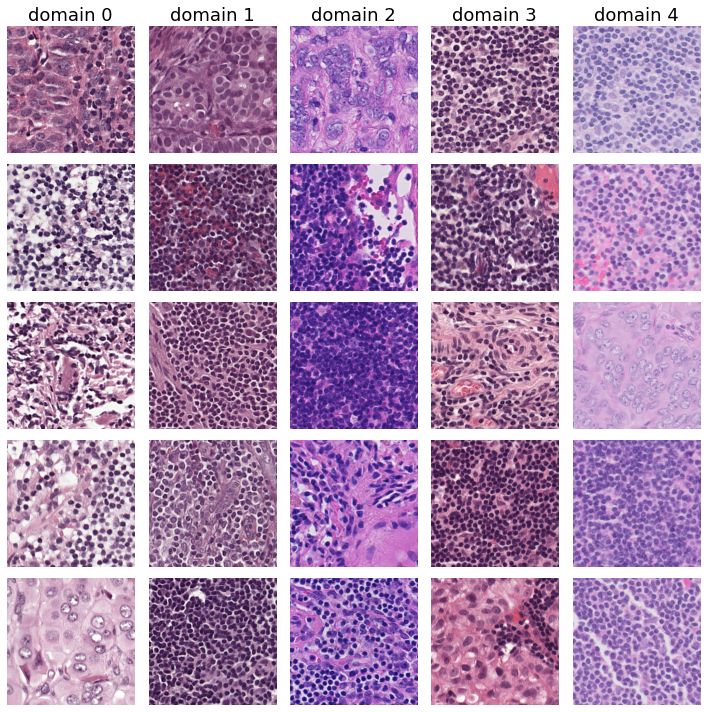

In [3]:
# plot all images
rows, columns, img_size = 5, 5, 2

plt.figure(figsize=(columns * img_size, rows * img_size))
for i in range(rows * columns):
    img = torch.load(tiles_dir + tile_names[i])

    plt.subplot(rows, columns, (i % columns) * columns + (i // columns) + 1)
    plt.imshow(img.permute(1, 2, 0))
    if i % 5 == 0:
        plt.title(f'domain {i // 5}', fontsize=18)
    plt.axis('off')
plt.tight_layout()


### Initialize and load HistAuGAN

In [29]:
model = MD_multi(opts)
model.resume(opts.resume, train=False) # todo: add path from google colab
model.eval();
print('--- model loaded ---')

--- model loaded ---


### Same attribute, other domains

In [34]:
# choose a sample tile
domain = np.random.randint(5)
img_id = np.random.randint(5)

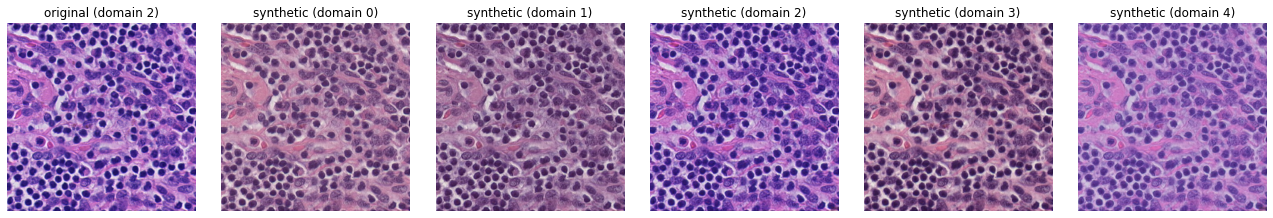

In [35]:
rows, columns, img_size = 1, 6, 3
plt.figure(figsize=(columns * img_size, rows * img_size))

img = torch.load(tiles_dir + tile_names[domain * 5 + img_id])
plt.subplot(rows, columns, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f'original (domain {domain})')
plt.axis('off')

z_content = model.enc_c(img.sub(0.5).mul(2).unsqueeze(0))

for i in range(rows * columns - 1):
    out = generate_hist_augs(img, domain, model, z_content, same_attribute=True, new_domain=i, stats=(mean_domains, std_domains))

    plt.subplot(rows, columns, i + 2)
    plt.imshow(out.add(1).div(2).permute(1, 2, 0))
    plt.title(f'synthetic (domain {i})')
    plt.axis('off')

plt.tight_layout()

### Random attribute, discrete domains

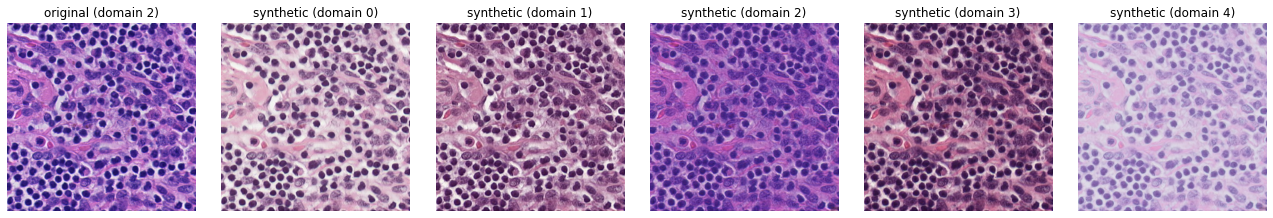

In [37]:
rows, columns, img_size = 1, 6, 3
plt.figure(figsize=(columns * img_size, rows * img_size))

img = torch.load(tiles_dir + tile_names[domain * 5 + img_id])
plt.subplot(rows, columns, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f'original (domain {domain})')
plt.axis('off')

z_content = model.enc_c(img.sub(0.5).mul(2).unsqueeze(0))

for i in range(rows * columns - 1):
    out = generate_hist_augs(img, domain, model, z_content, new_domain=i, stats=(mean_domains, std_domains))

    plt.subplot(rows, columns, i + 2)
    plt.imshow(out.add(1).div(2).permute(1, 2, 0))
    plt.title(f'synthetic (domain {i})')
    plt.axis('off')

plt.tight_layout()

### Random attributes, interpolated domains

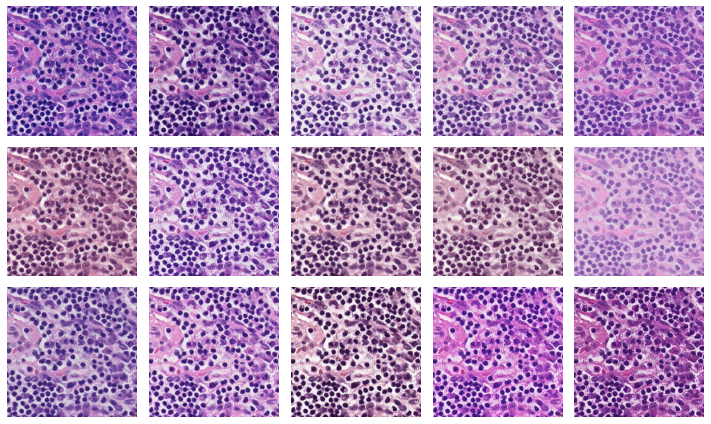

In [38]:
rows, columns, img_size = 3, 5, 2
plt.figure(figsize=(columns * img_size, rows * img_size))

img = torch.load(tiles_dir + tile_names[domain * 5 + img_id])
plt.subplot(rows, columns, 1)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')

z_content = model.enc_c(img.sub(0.5).mul(2).unsqueeze(0))

for i in range(rows * columns - 1):
    out = generate_hist_augs(img, domain, model, z_content, new_domain=torch.rand(5).unsqueeze(0) * 2 - 0.5)

    plt.subplot(rows, columns, i + 2)
    plt.imshow(out.add(1).div(2).permute(1, 2, 0))
    plt.axis('off')
    
plt.tight_layout()

## Qualitative evaluation by expert pathologist

We checked the quality of HistAuGAN augmentations by an expert pathologist on the structural similarity of original and augmented WSI tiles from the training set, i.e., the Camelyon17 dataset, and an unseen dataset of breast tissue [13]. 
<!-- todo add correct reference here -->

We define three levels of similarity: 

1. High similarity: a pathologist would find it difficult to distinguish the original tile from the augmented tile
2. Moderate similarity: some structural variations are observed, but do not affect pathological diagnosis
3. Low similarity: the augmentated tiles can not be used for diagnostic purposes

In the images below, you can see the paired tiles with the orginal image on the left side and the augmented image on the right side that we used for our qualitative evaluation. The pairs are clustered and framed according to their similarity level evaluated by our expert pathologist.

As shown in the table below, most of the augmented images do not have a structural modification that affects diagnosis and over half of them can even fool an expert pathologist. It is worth to mention that HistAuGAN is not trained on any of the breast cancer images but is still able to transfer its color in a structure-preserving manner.

Tissue Type | High | Mid | Low | Total
--- | --- | --- | --- | --- 
Lymph nodes | 10 | 8 | 2 | 20
Breast | 14 | 4 | 2 | 20

### Lymph node tissue (Camelyon17)

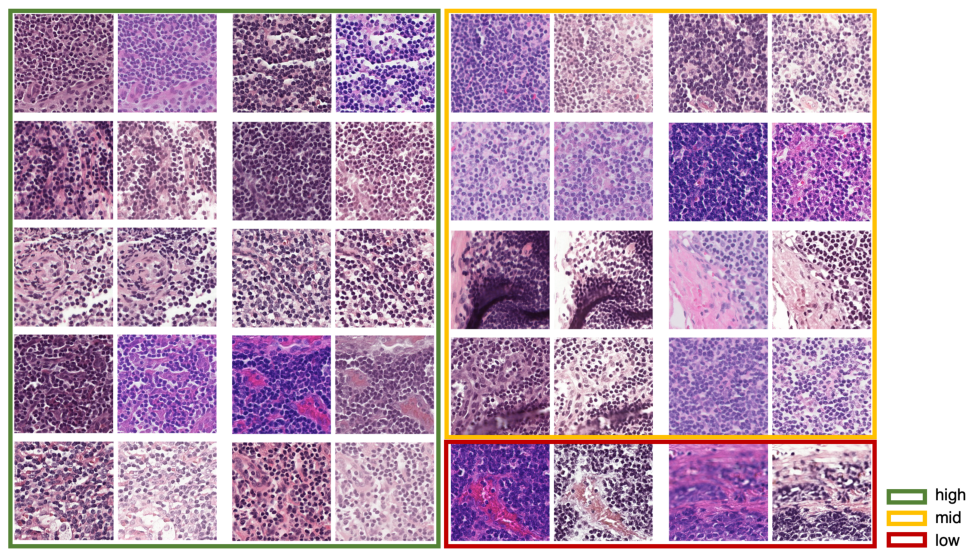

In [7]:
lymph = Image.open('qual_eval_lymphnodes.png')
plt.figure(figsize=(20, 10))
plt.imshow(lymph)
plt.axis('off');

### Breast tissue (unseen dataset)

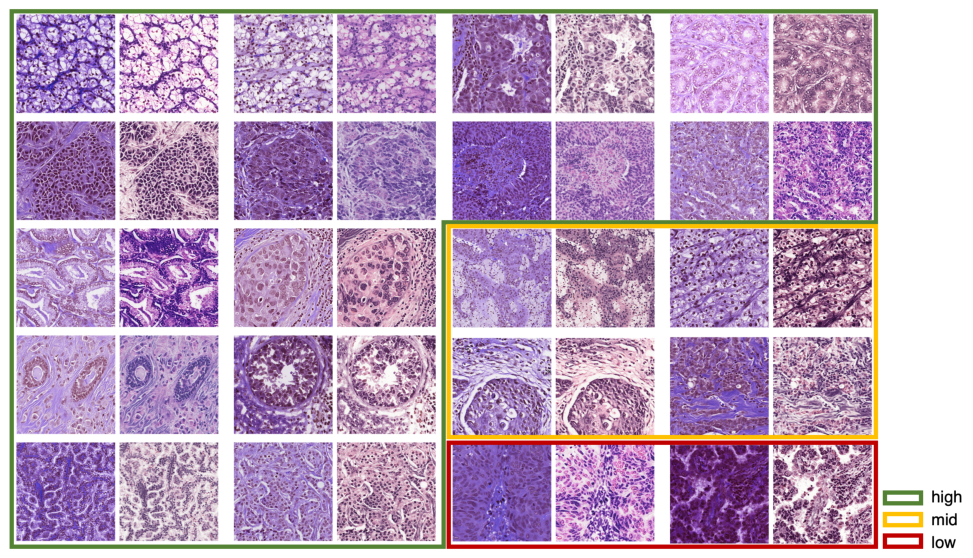

In [8]:
lymph = Image.open('qual_eval_breast.png')
plt.figure(figsize=(20, 10))
plt.imshow(lymph)
plt.axis('off');